# Import Libraries

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
from statsmodels.tsa.stattools import adfuller, kpss

# EDA

## Load dataset

The dataset is taken from here https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality/data and from the web page:

“<i>This dataset contains information about various attributes of a set of fruits, providing insights into their characteristics. The dataset includes details such as fruit ID, size, weight, sweetness, crunchiness, juiciness, ripeness, acidity, and quality.</i>”

In [4]:
#Load the dataset into a dataframe, the data is separated by a comma and the the index column is the 'A_id' one.
df = pd.read_csv('apple_quality.csv', sep=',', index_col=['A_id'])

## Information about the data

On this section we will explorate how is the dataset composed and how many columns and rows does it have. After that we will check the quality of the data investigating on the nan values or the None.

### First investagion

#### First look

In [3]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
A_id,,,,,,,,
0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


#### Size

In [4]:
print(df.shape)

(4001, 8)


The dataset is composed of 4001 rows and 8 columns so in total there are 32008 values.


#### Descriptive statistics

Descriptive statistics are numerical and graphical methods used to summarize and describe the main features of a dataset. They provide a concise summary of the essential characteristics, patterns, and trends within the data. Common descriptive statistics include measures of central tendency (mean, median, mode) and measures of variability (range, variance, standard deviation).


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837


From this is possible to see that we're working with numerical data, note that the Quality column is note on the describe because it is an object value (string) and so it is not possible to see it's statistics yet. The data we are working it is already scaled this is why we have negative values. The author of this dataset did not say which was the transformation but this will simplify the modeling part. Moreover the data has low values, we can see that the highest value is from the Acidity column with a value of 7.404736 and the lowest one is the Size column with -7.151703.

### Data type and Null

The dataframe info command gives us interesting informations about the types of the columns, the number of the null values and the dimension of the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4001 entries, 0.0 to nan
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4001 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 281.3+ KB


From the 4001 entries, we see that there is a null value on all the columns except for the acidity one. To have a better look the command isnull() gives us all the information that we need.

In [7]:
df.isnull().sum()

Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

All of the features except one have a null value, so an important question comes to our mind: are those nan values in the same row or are those in different rows? To ask this question we need to dig deeper and see where the columns are none.

In [8]:
df[df.Quality.isna()]

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
A_id,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


So this reflects our intuition, all the null values are on the same row, so it's a good choice to remove this row and have a clean dataset to use. If the lecturer is interested in why those rows are null then the .csv file is incorrect on the last line which is this one

“<i>,,,,,,,Created_by_Nidula_Elgiriyewithana,</i>”


In [5]:
df.dropna(inplace=True)

Looking into the null values we see that our dataset is now clean

In [10]:
df.isnull().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

A last check to do is to see if there are duplicated rows in the dataset, a lot number of duplicated rows would impact the performance of the models.

In [11]:
df.duplicated().sum()

0

The rows duplicated are zero so we can continue without problems.

### Acidity

The Acidity column is an object type but looking more into the data it's possible to see that all the values are numbers, so it's a good choice to convert the dtype of the column into float64 to be more coincise

In [6]:
df[['Acidity']] = df[['Acidity']].apply(pd.to_numeric, errors='coerce')

### Quality

The quality column is the other one who has a object type, but if we look more closer into the data we see that it's a categorical feature. 

A categorical feature is a type of variable in statistics and machine learning that represents categories or labels. Unlike numerical features, which have values that are numbers and can be treated as quantities, categorical features consist of distinct groups or classes

In [7]:
df.Quality.unique()

array(['good', 'bad'], dtype=object)

The quality columns only assumes two values 'good' or 'bad'. There are a lot of ways to work with categorical data but since we only have two case the label encoding is a simpler solution.

In [8]:
df['Quality'] = df['Quality'].map({'good' : 1, 'bad':0})

Now the dataset look like this

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0.0 to 3999.0
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Quality      4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110270,-7.010538,-1.377424,0.022609,1.510493,7.404736
Quality,4000.0,0.501000,0.500062,0.000000,0.000000,1.000000,1.000000,1.000000


## Plot of the data

array([[<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>],
       [<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>],
       [<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>],
       [<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>]], dtype=object)

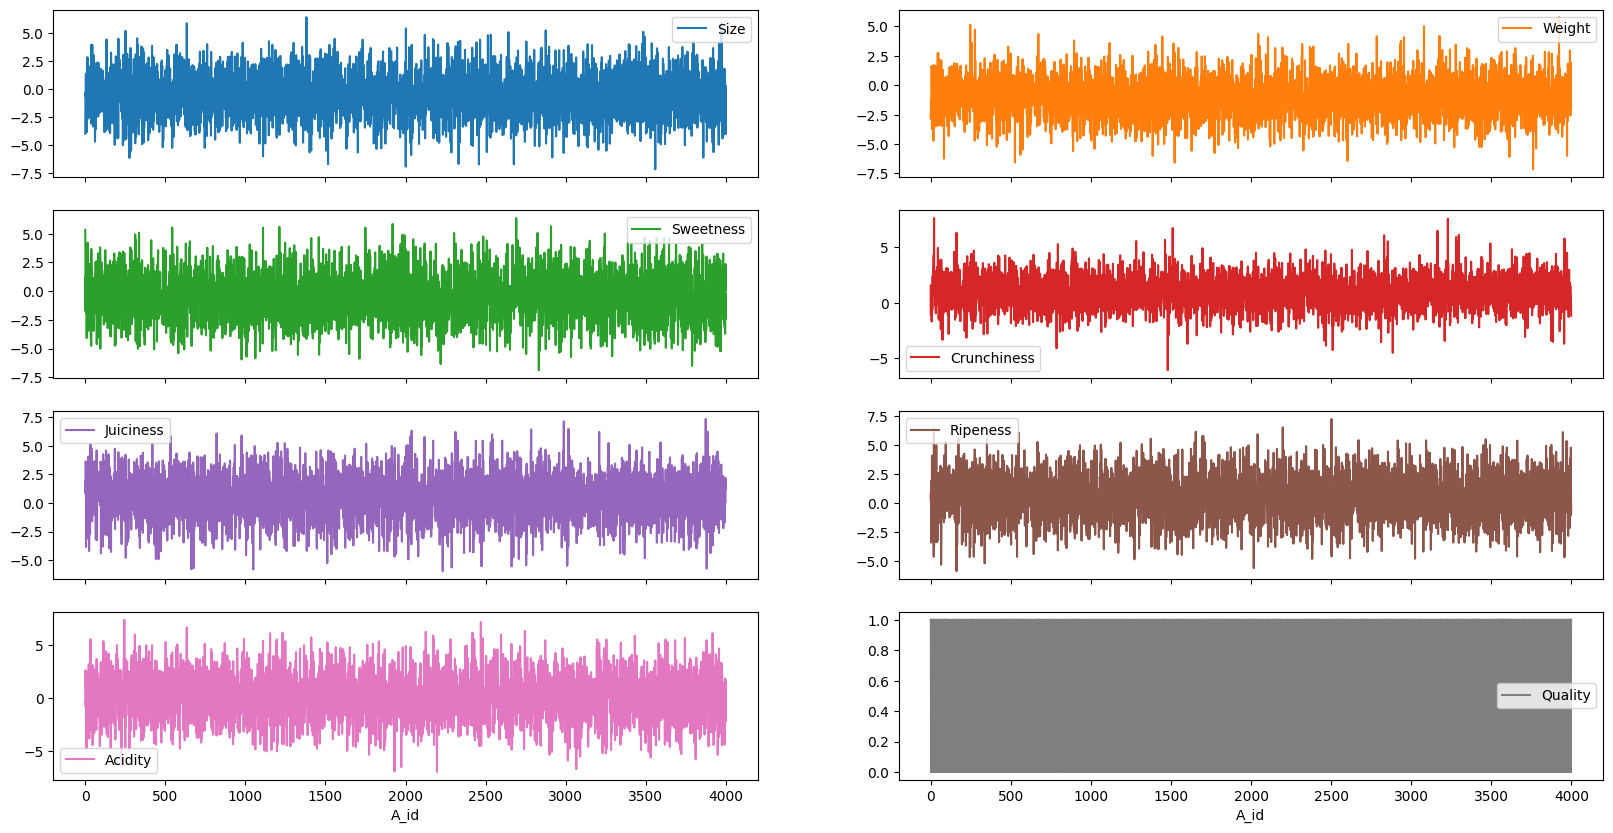

In [17]:
df.plot(subplots = True, figsize=(20,10), layout=(4,2))

From these plots it's not so clear of which type of data we're working with, those graphs seems a lot white noise (https://en.wikipedia.org/wiki/White_noise), the only one who differs is the quality in which only assumes value of 0 and 1 and so it has a rectangular shape as expected.

## Distribution of the data

<Axes: >

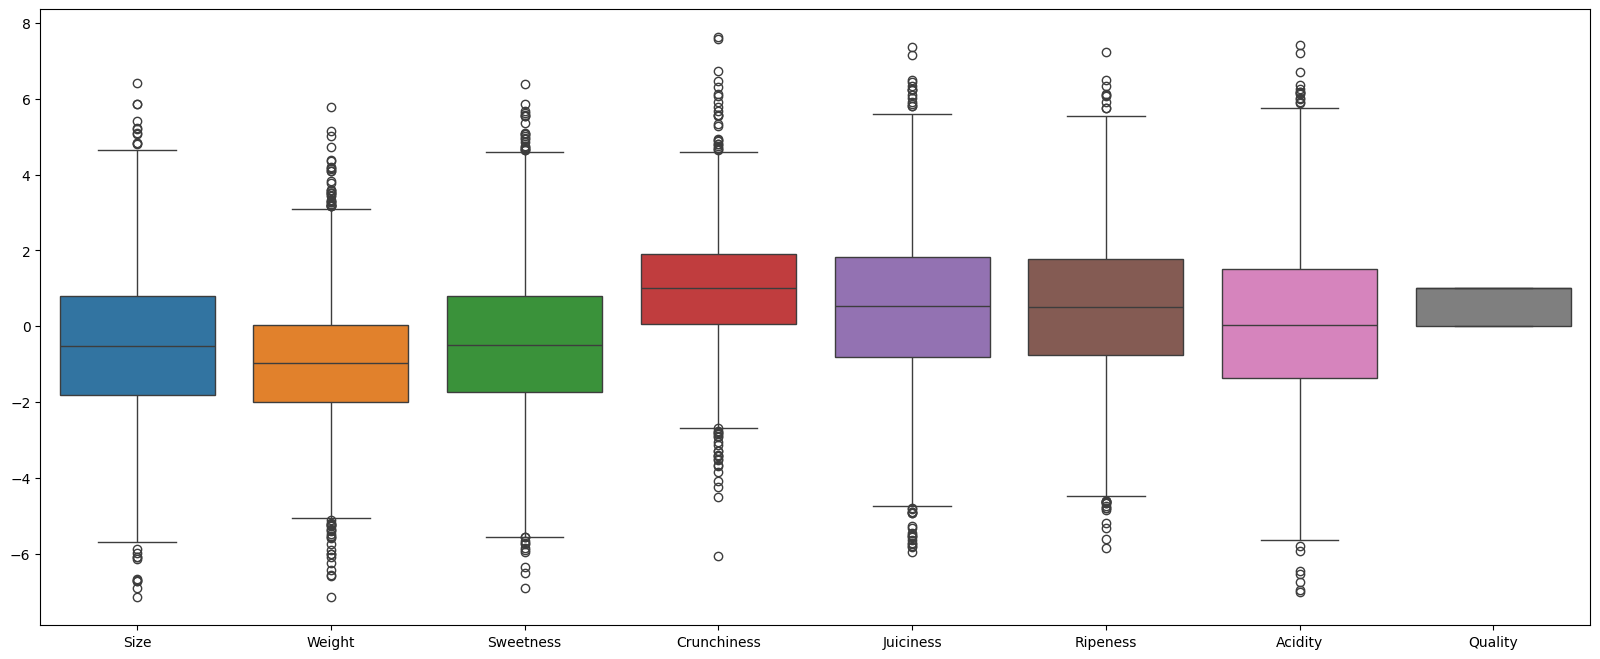

In [18]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(df) 

### Stationary test

https://www.quora.com/Is-it-necessary-to-have-stationary-data-to-apply-any-kind-of-machine-learning-algorithm

The data is showing a stationary pattern with a little bit of noise.

## Stationary of the data

In [19]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  if adf_test[1] <= 0.05:
    return True
  return False
#Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  if kpss_out[1] <= 0.05:
    return False
  return True

In [20]:
adfuller_test(df.Size)
kpss_test(df.Size)
df_stationary_results =  pd.DataFrame(columns=['Feature','KPSS','ADF'])
for column in df.columns:
    stationary_column_res_series = pd.Series({'Feature':column,'KPSS': kpss_test(df[column]), 'ADF':adfuller_test(df[column])})
    df_stationary_results = pd.concat([df_stationary_results, stationary_column_res_series.to_frame().T])

df_stationary_results.index = df_stationary_results.Feature
df_stationary_results.drop(['Feature'], inplace=True, axis=1)

In [21]:
df_stationary_results

,KPSS,ADF
Feature,,
Size,True,True
Weight,True,True
Sweetness,True,True
Crunchiness,True,True
Juiciness,True,True
Ripeness,True,True
Acidity,True,True
Quality,True,True


This is a really good sign because all the features are stationary and this means that shifting all time instants by some fixed amount gives the same probabilistic de- scription of the random variables. In practical terms the distribution stay the same after a displacement

## Dive into the distribution of the data

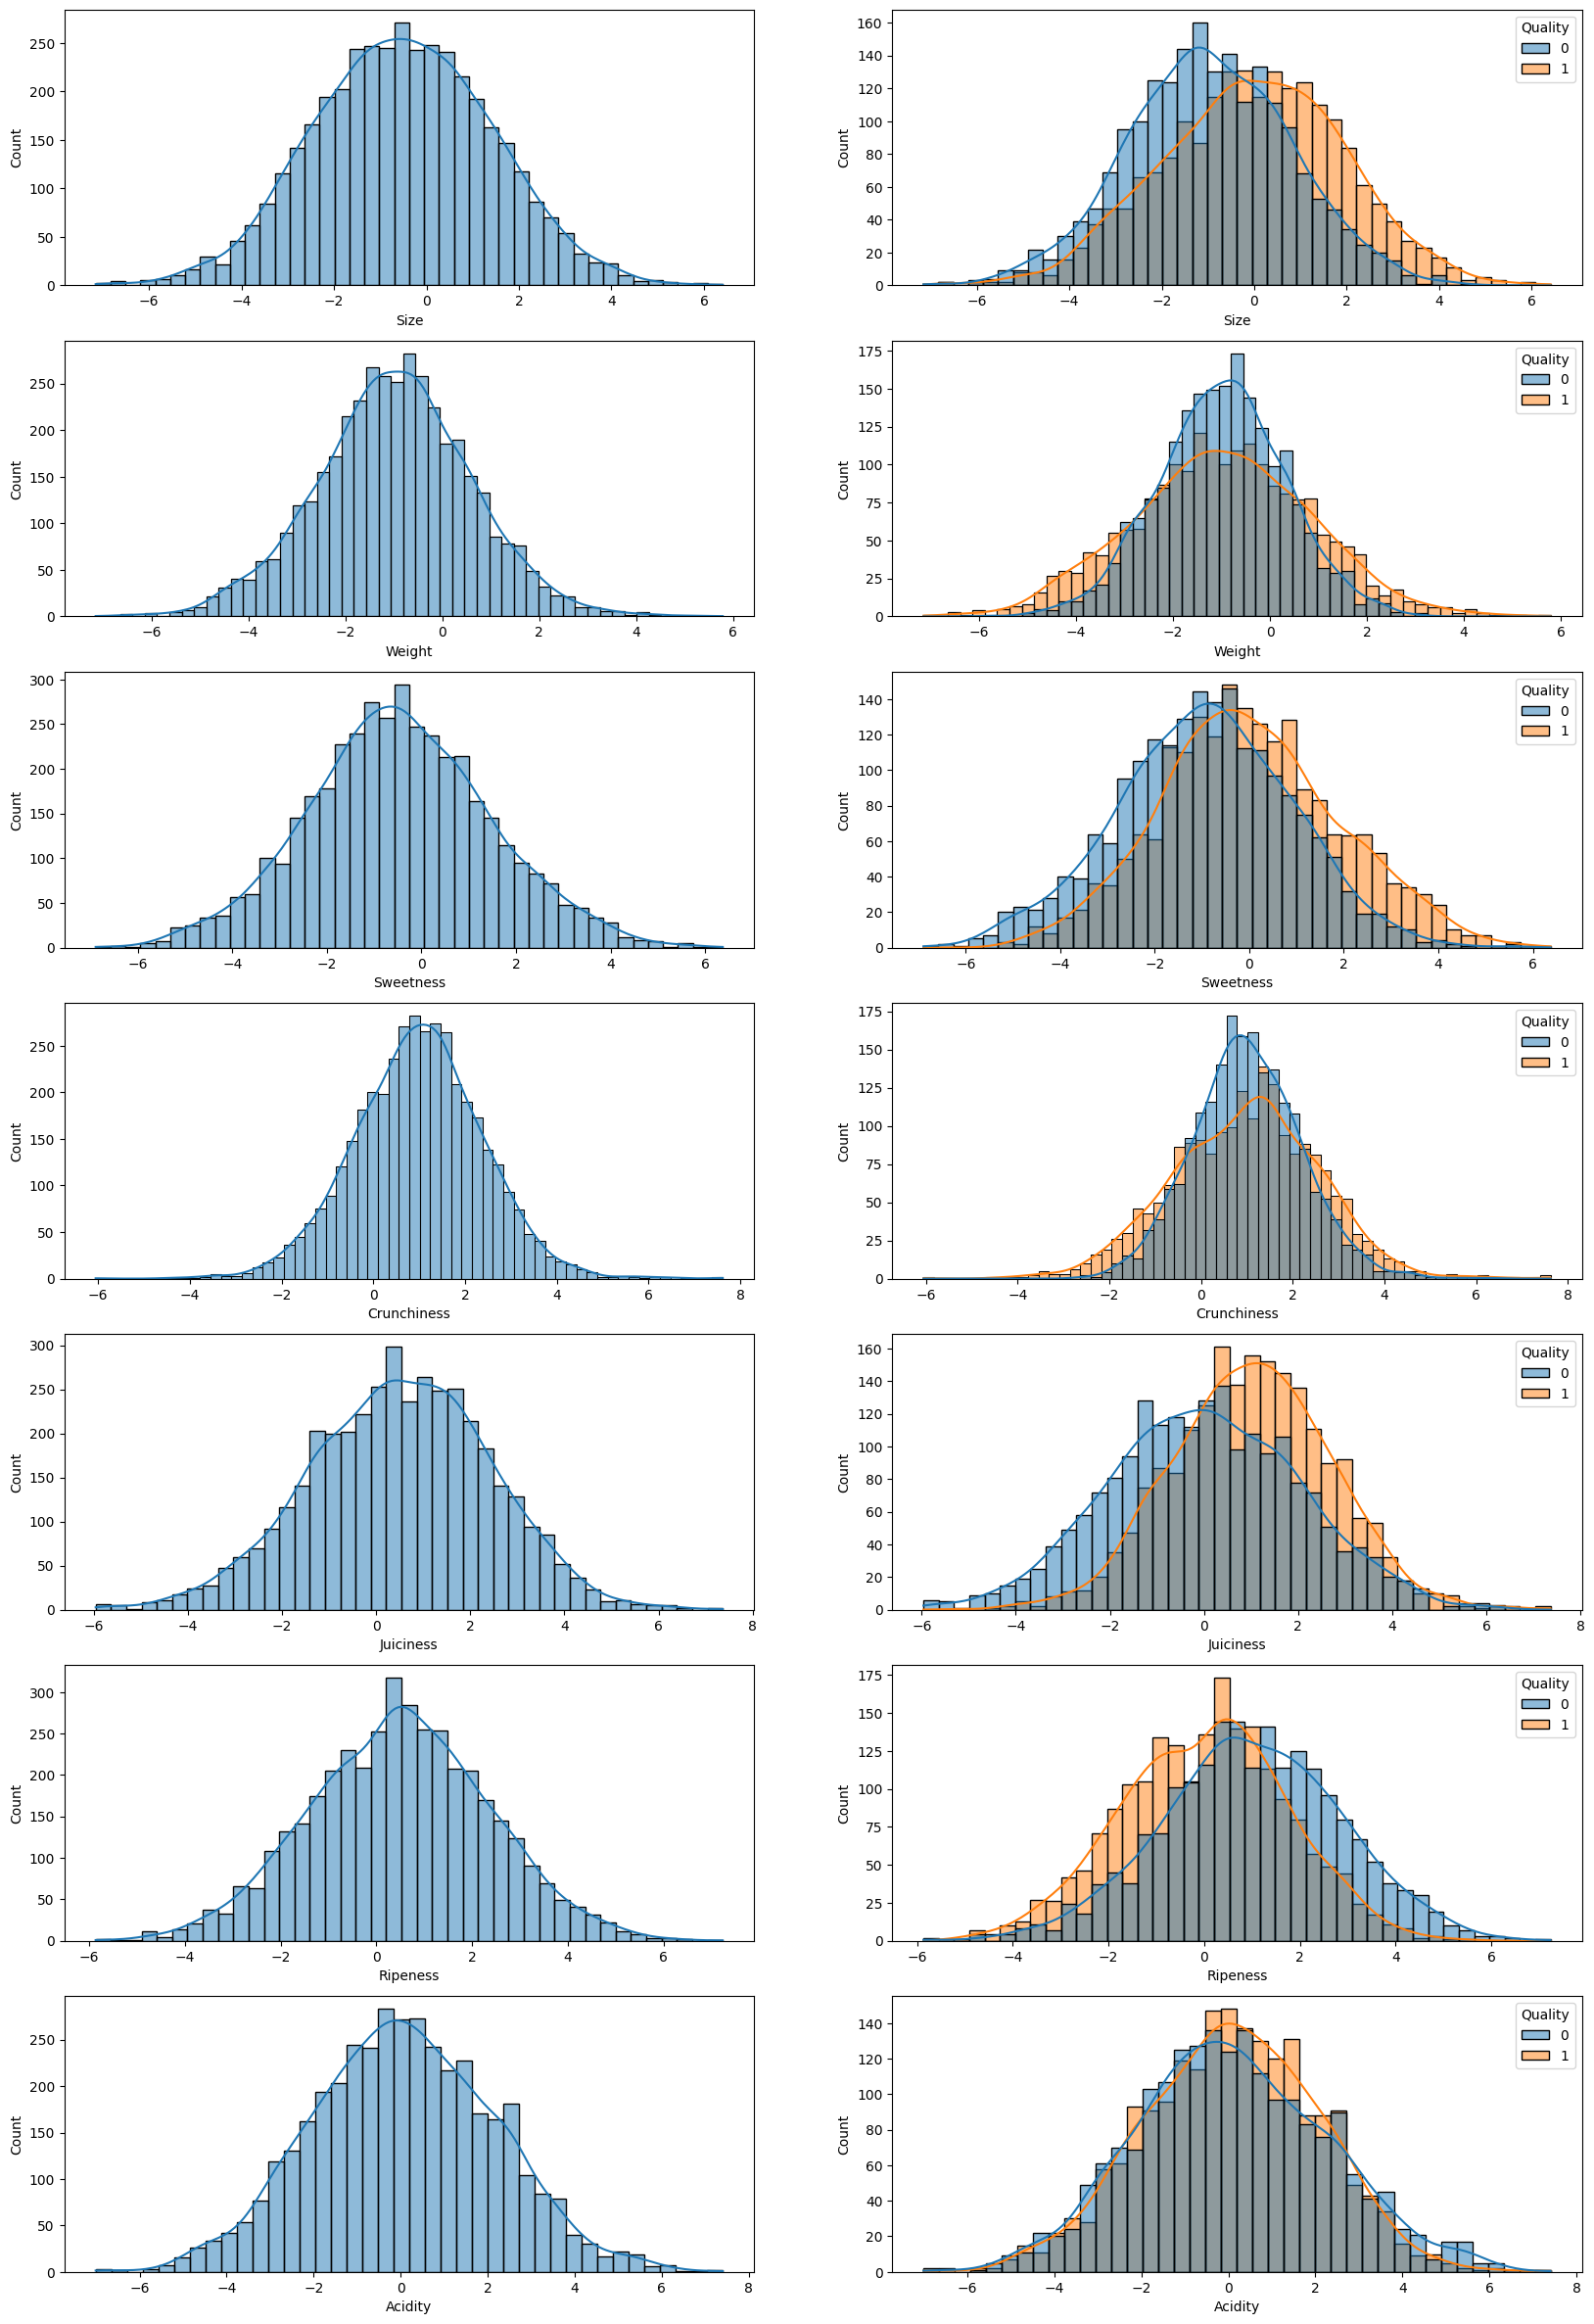

In [22]:
fig, axes = plt.subplots(7,2, figsize=(20,30))
for i in range(7):
    sns.histplot(data=df, x=df.columns[i], ax=axes[i][0], kde=True)
    sns.histplot(data=df, x=df.columns[i], ax=axes[i][1], hue='Quality', kde=True)

To the left can be seen the distribution of the single feature, to the right we can see the distribution for the values with quality equals to 1 and equals to 0.
With and without considering the quality parameter, it's possible to see that the data is somewhat following a normal distribution.

## Test for normal distribution

<Axes: >

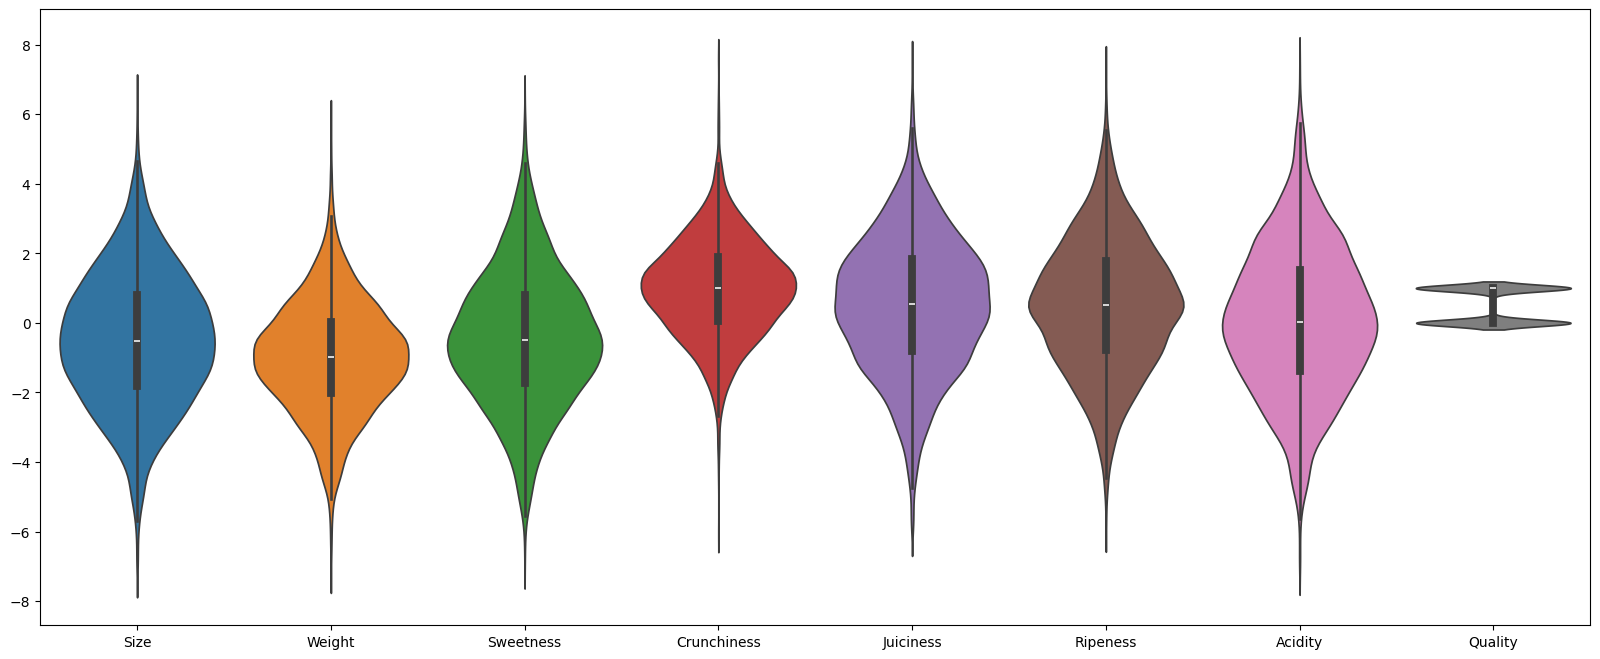

In [23]:
fig = plt.figure(figsize=(20,8))
sns.violinplot(df) 

In [24]:
for column in df.columns:
    q1 = df[column].quantile(.25)
    q3 = df[column].quantile(.75)
    mask = (df[column] > 1.5* q3) | (df[column] < 1.5 * q1)
    print(10*'*', column, 10*'*')
    print("Q1: ",q1, "\nQ3: ",q3)
    print('Number of Outliers: ',df[column][mask].size)

********** Size **********
Q1:  -1.816764527 
Q3:  0.8055264495000001
Number of Outliers:  1264
********** Weight **********
Q1:  -2.01177029275 
Q3:  0.03097644
Number of Outliers:  1394
********** Sweetness **********
Q1:  -1.7384250625 
Q3:  0.8019219209999999
Number of Outliers:  1289
********** Crunchiness **********
Q1:  0.06276439525000001 
Q3:  1.8942342170000002
Number of Outliers:  1366
********** Juiciness **********
Q1:  -0.80128581525 
Q3:  1.8359763875
Number of Outliers:  1237
********** Ripeness **********
Q1:  -0.7716768665 
Q3:  1.76621164075
Number of Outliers:  1284
********** Acidity **********
Q1:  -1.3774240784999998 
Q3:  1.510492756
Number of Outliers:  1266
********** Quality **********
Q1:  0.0 
Q3:  1.0
Number of Outliers:  0


The density function of the data is very similar to a normal one, so let's test it with the stats.normaltest methods from the stats package.
The normaltest (https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test) is a goodness-of-fit measure of departure from normality, that is the test aims to gauge the compatibility of given data with the null hypothesis that the data is a realization of independent, identically distributed Gaussian random variables.

In [ ]:
normal_res_df = pd.DataFrame(columns=['Name','Normal'])
for col in df.columns:
    statistic, pvalue = stats.normaltest(df[col])
    if pvalue < 0.05:
        res_series = pd.Series({'Name':col, 'Normal': False})
    else:
        res_series = pd.Series({'Name':col, 'Normal': True})
    normal_res_df = pd.concat([normal_res_df, res_series.to_frame().T])
normal_res_df.index = normal_res_df.Name
normal_res_df.drop('Name',inplace=True,axis=1)
normal_res_df.sort_values(by='Normal',inplace=True, ascending=False)

In [ ]:
display(normal_res_df)

So from all these features, only 4 of them can be assumed to be from a normal distribution. This is a good thing because the norma

In [ ]:
correlation_matrix_df = df.corr()
fig = plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(correlation_matrix_df, dtype=bool))
sns.heatmap(correlation_matrix_df,annot=True, mask = mask)

Correlation with Quality:
* Size has a positive correlation of 0.24, suggesting a moderate positive relationship.
* Weight has a very weak positive correlation of 0.0014, almost negligible.
* Sweetness has a weak positive correlation of 0.25.
* Crunchiness has a very weak negative correlation of -0.012.
* Juiciness has a weak positive correlation of 0.26.
* Ripeness has a weak negative correlation of -0.26.
* Acidity has a very weak negative correlation of -0.0077.

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.histplot(df, x = 'Quality', hue='Quality')

In [ ]:
df_quality = df['Quality'].value_counts().to_frame()
labels = df_quality.index.to_list()
values = df_quality.iloc[:,0].to_list()

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (4,4))
ax.pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':10, 'fontweight':'bold'})
ax.legend(labels)
ax.set_title("Quality", fontsize = 14, fontweight = "bold", color = "black")

# Classification

The aim of this part is to classify whether an apple has a good or bad quality. The columns are divided in two parts: the predictors and the predicted value. The predictor columns are composed of 7 features: Size, Weight, Acidity, Ripeness, Sweetness, Juiciness and Crunchiness, the value we want to predict is the Quality. We'll start with a Tree decision Classifier then moving to a SVC and lastly to a Neural network. Lastly we will compare the different models and see which is the best one.

## Import of the libraries

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB, BernoulliNB

## Prepare the data

In [11]:
X = df.drop('Quality',axis=1).values
y = df['Quality'].values
print(X.shape)
print(y.shape)

(4000, 7)
(4000,)


### Divide the dataset into train and test set

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

3.7684141521562455e-16

### Model evaluation

In [64]:
class Model:
    def __init__(self, model,name=None, scaled=False):
        self.model = model
        self.name = name
        self.scaled = scaled
    def fit(self):
        if self.scaled:
            self.model.fit(X_train_scaled, y_train)
        else:
            self.model.fit(X_train, y_train)
    def __get_predictions(self):
        if self.scaled:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        else:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc
        }, name=self.name)
        if self.name == '' or self.name is None:
            metrics_series.name = name='Metrics ' + type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

In [19]:
models = list()

## Naive Bayes

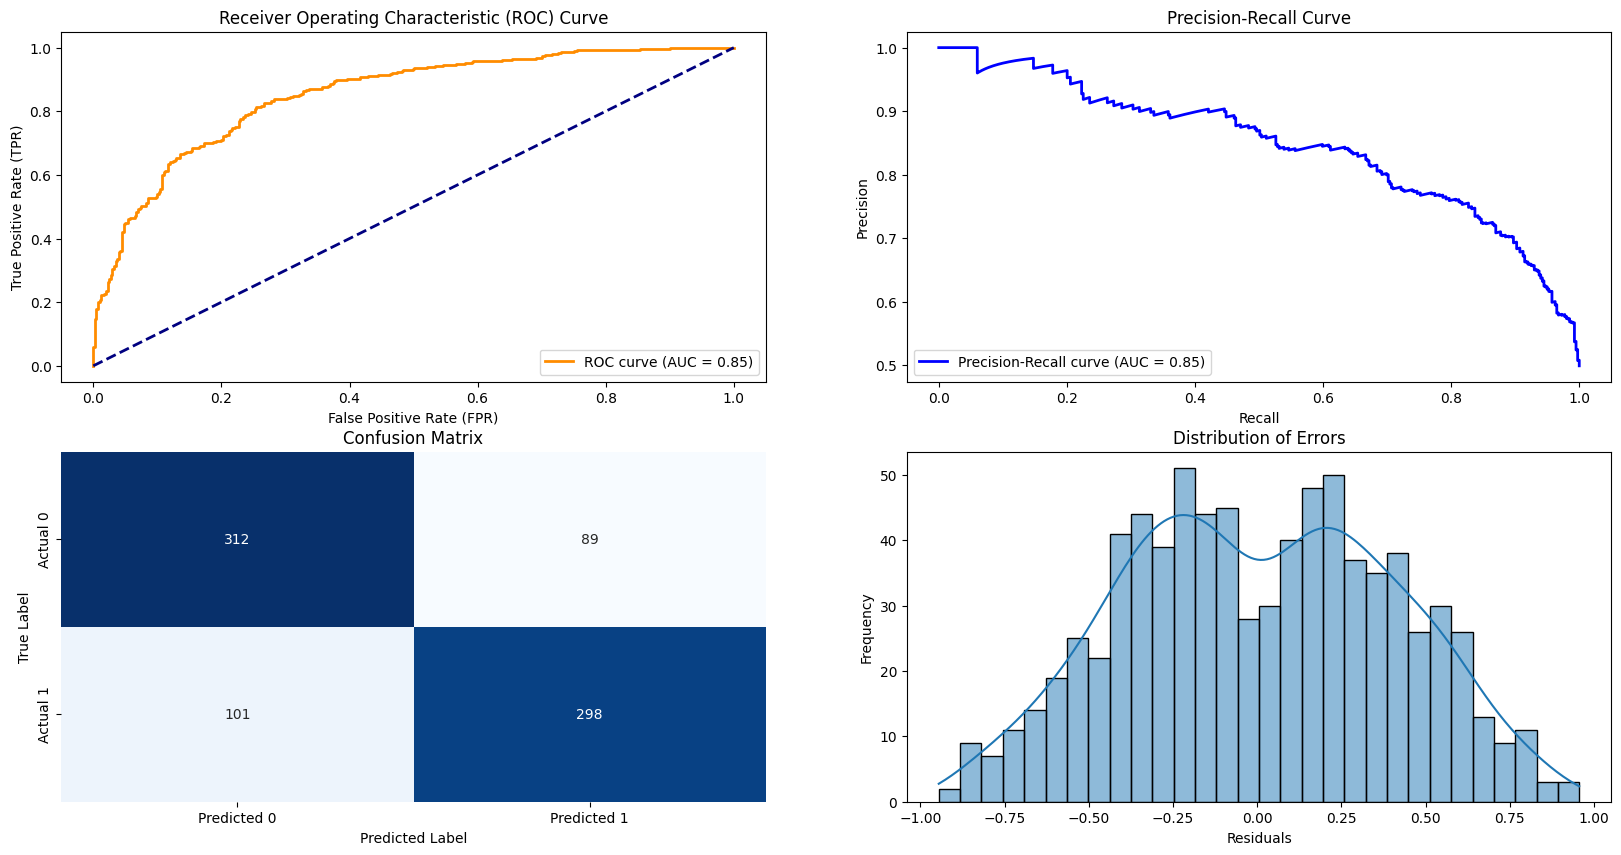

In [65]:
model = Model(GaussianNB())
model.fit()
model.visualize_metrics()

In [66]:
model.get_metrics()

Accuracy                             0.7625
Precision                          0.770026
Recall                             0.746867
F1-Score                            0.75827
ROC AUC                            0.850899
Confusion Matrix    [[312, 89], [101, 298]]
PR AUC                             0.846821
Name: Metrics GaussianNB, dtype: object

### Bernoulli Naive Bayes

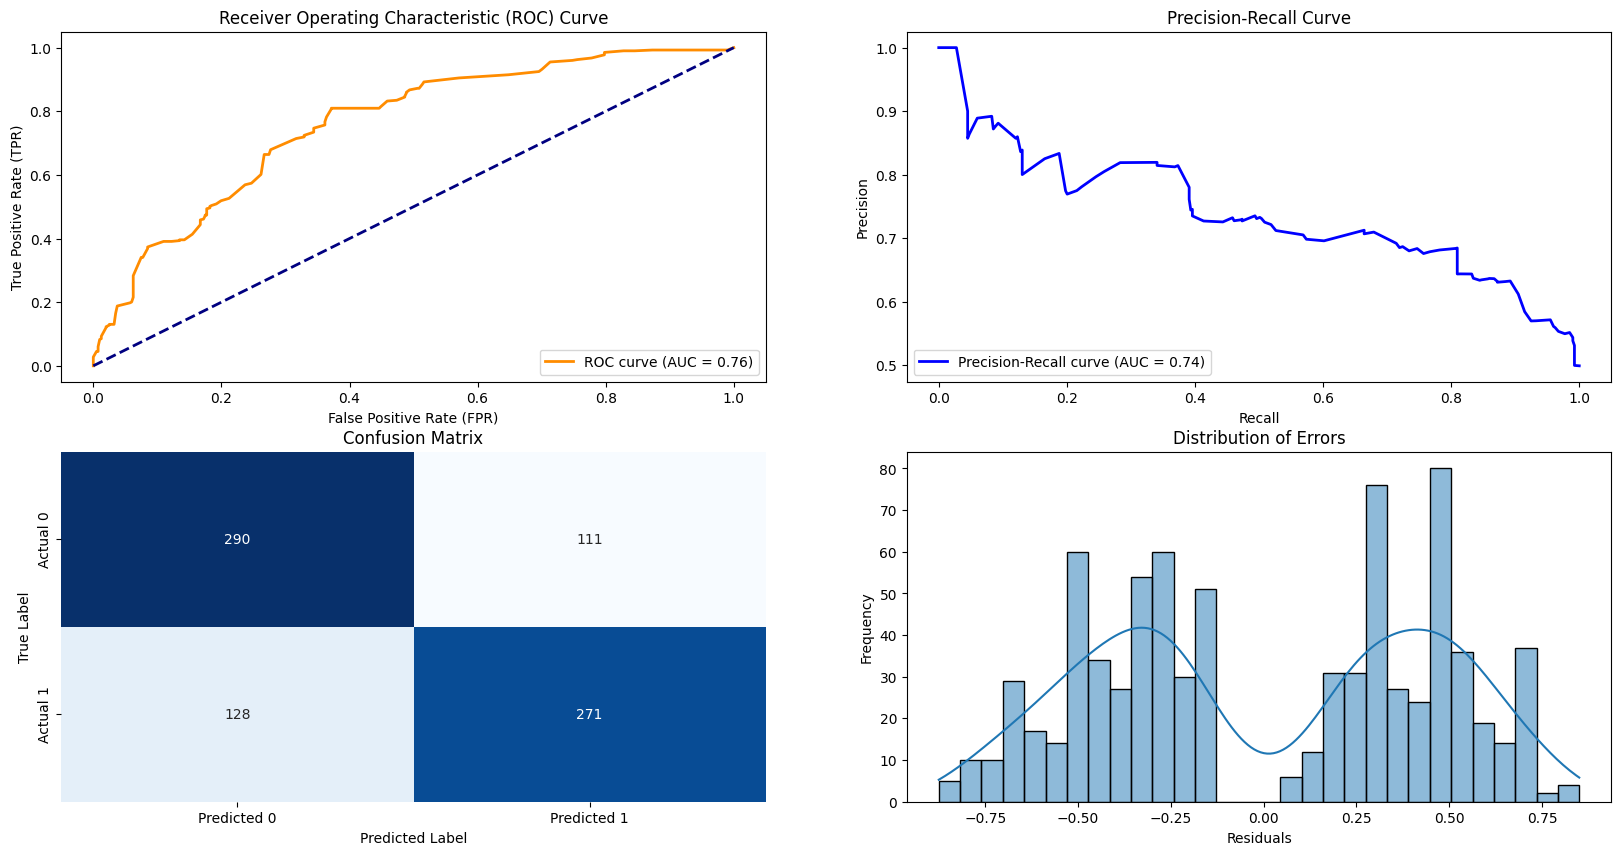

In [67]:
model = Model(BernoulliNB())
model.fit()
model.visualize_metrics()

In [61]:
model.get_metrics()

Accuracy                             0.70125
Precision                           0.709424
Recall                              0.679198
F1-Score                            0.693982
ROC AUC                             0.759252
Confusion Matrix    [[290, 111], [128, 271]]
PR AUC                              0.737735
Name: Metrics BernoulliNB, dtype: object

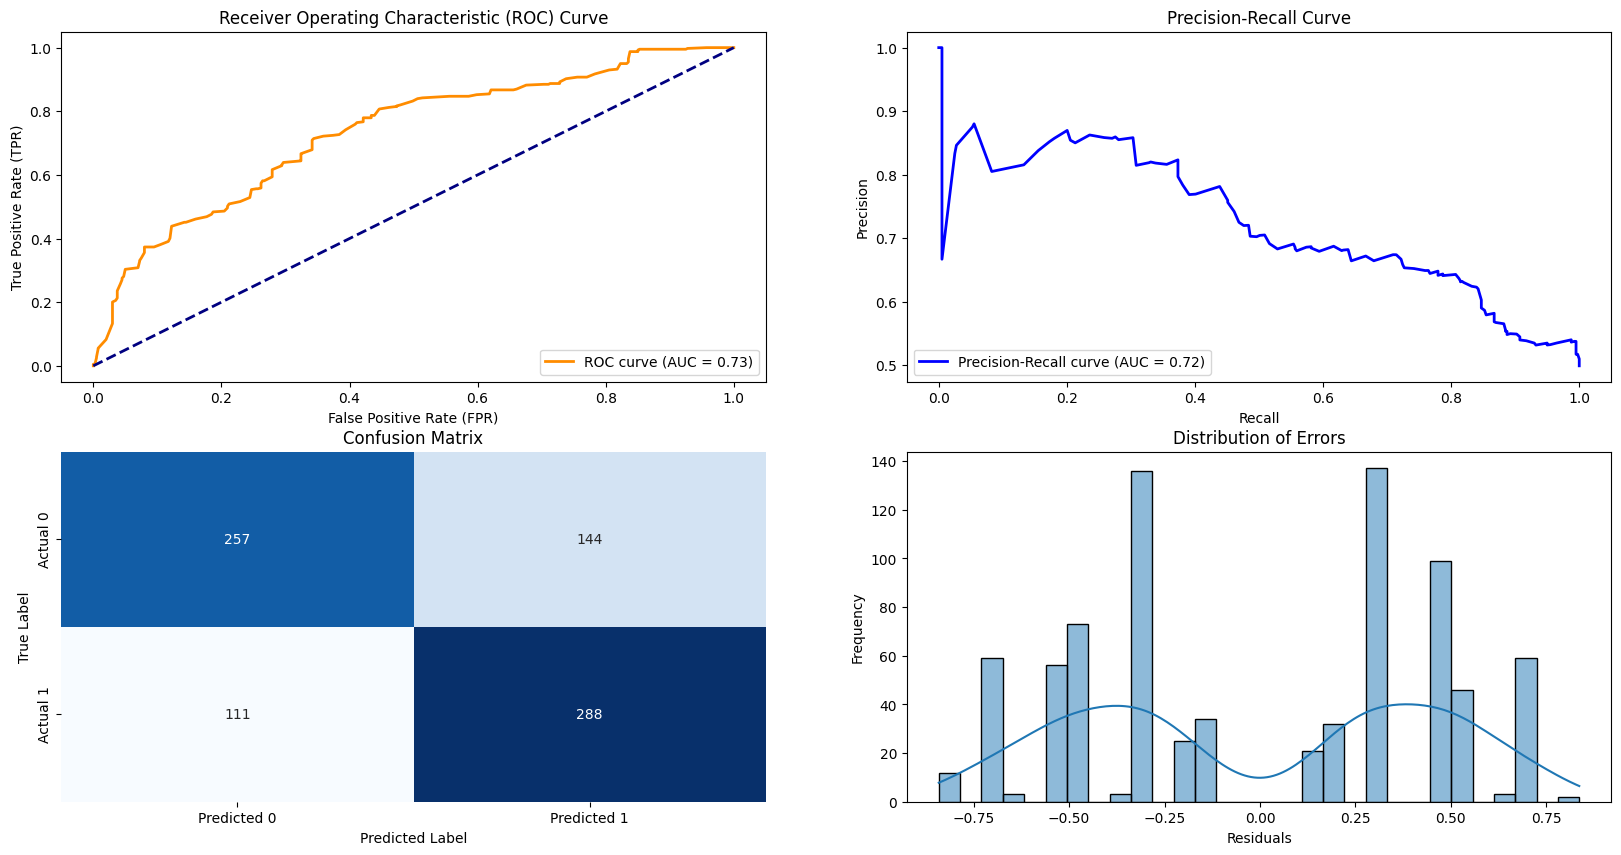

In [68]:
model = Model(BernoulliNB(),scaled=True)
model.fit()
model.visualize_metrics()

In [69]:
model.get_metrics()

Accuracy                             0.68125
Precision                           0.666667
Recall                              0.721805
F1-Score                            0.693141
ROC AUC                              0.73247
Confusion Matrix    [[257, 144], [111, 288]]
PR AUC                              0.724435
Name: Metrics BernoulliNB, dtype: object

## Logistic Regression

In [78]:
# Create the model
model = LogisticRegression()
#Fit the model
model.fit(X_train,y_train)

LogisticRegression()

In [88]:
#Evaluate the model
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]

In [89]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(r'R^2 Score: ',metrics.r2_score(y_test,y_pred))

Accuracy: 75.38%
R^2 Score:  0.014993843711522903


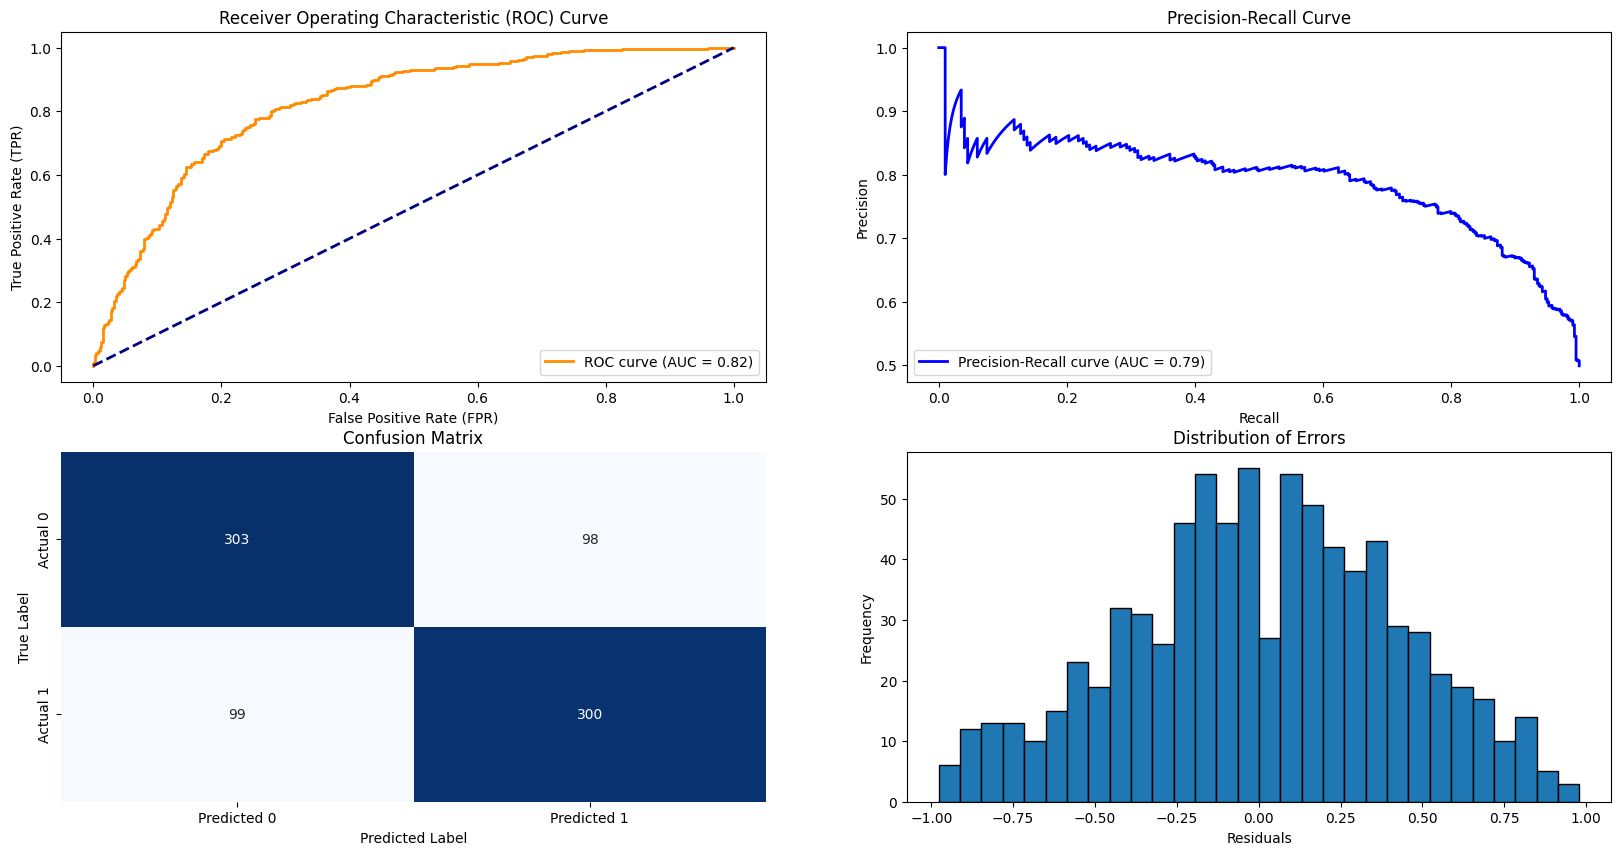

In [90]:
visualize_metrics(y_pred, y_test,y_probs)

### Scale the data

In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [92]:
# Create the model
model = LogisticRegression()
#Fit the model
model.fit(X_train_scaled,y_train)

LogisticRegression()

In [95]:
#Evaluate the model
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]

In [94]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(r'R^2 Score: ',metrics.r2_score(y_test,y_pred))

Accuracy: 75.88%
R^2 Score:  0.0349939687123042


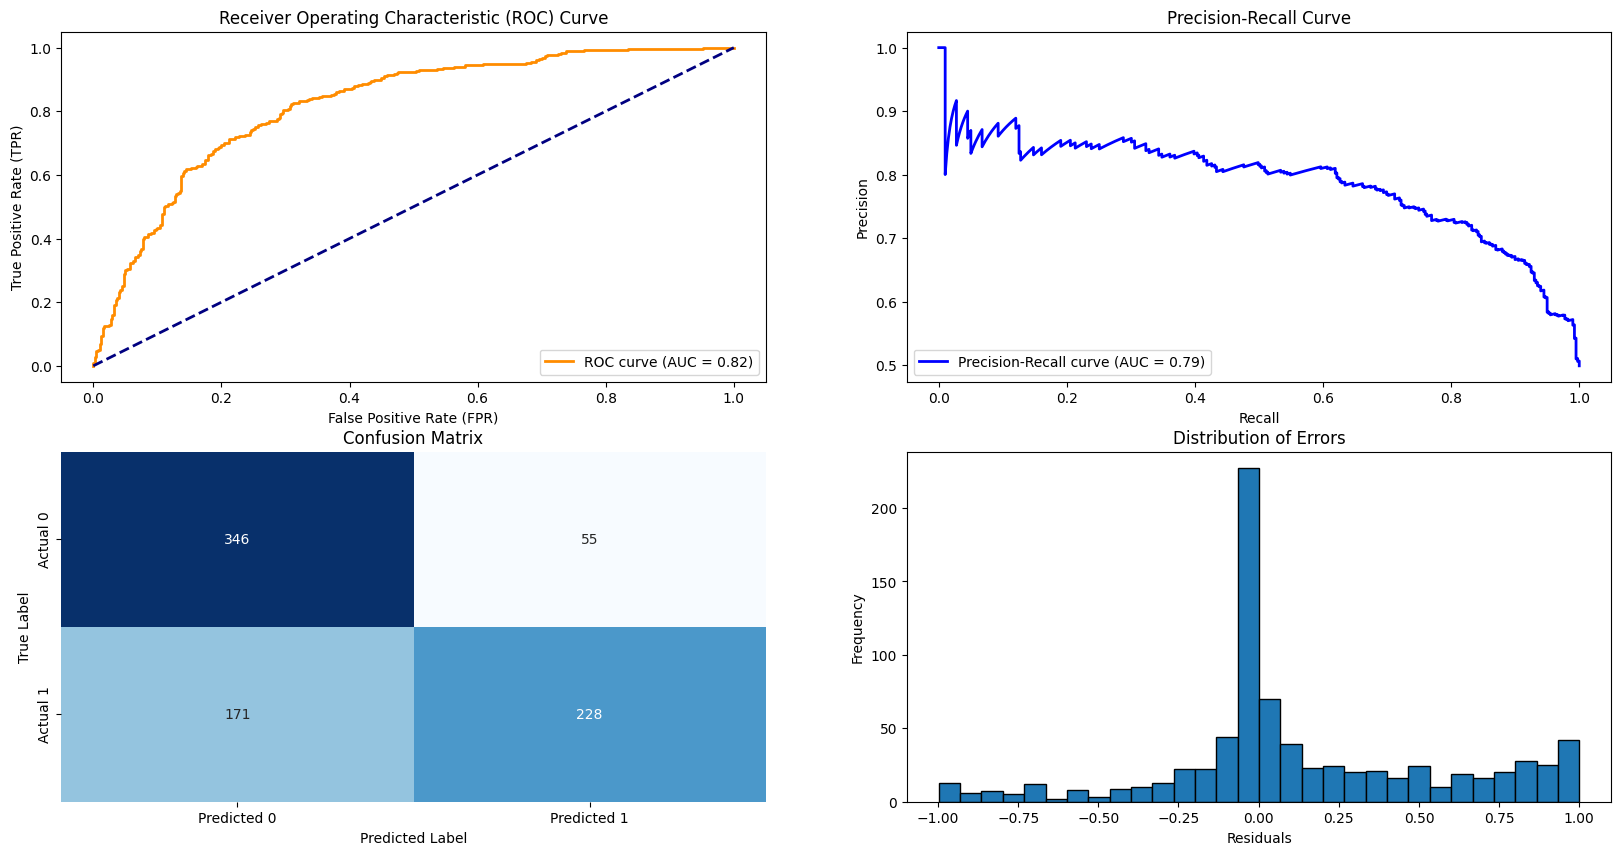

In [96]:
visualize_metrics(y_pred, y_test,y_probs)

### Best Logistic Regression Model

In [97]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)

In [ ]:
print(clf.best_params_)
#C  =10, penalty = L2, solver = liblinear

In [100]:
best_model = LogisticRegression(C = 10, penalty='l2', solver='liblinear')

In [101]:
best_model.fit(X_train_scaled, y_train)

LogisticRegression(C=10, solver='liblinear')

In [103]:
y_pred = best_model.predict(X_test_scaled)
y_probs = best_model.predict_proba(X_test_scaled)[:,1]

In [104]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(r'R^2 Score: ',metrics.r2_score(y_test,y_pred))

Accuracy: 75.88%
R^2 Score:  0.0349939687123042


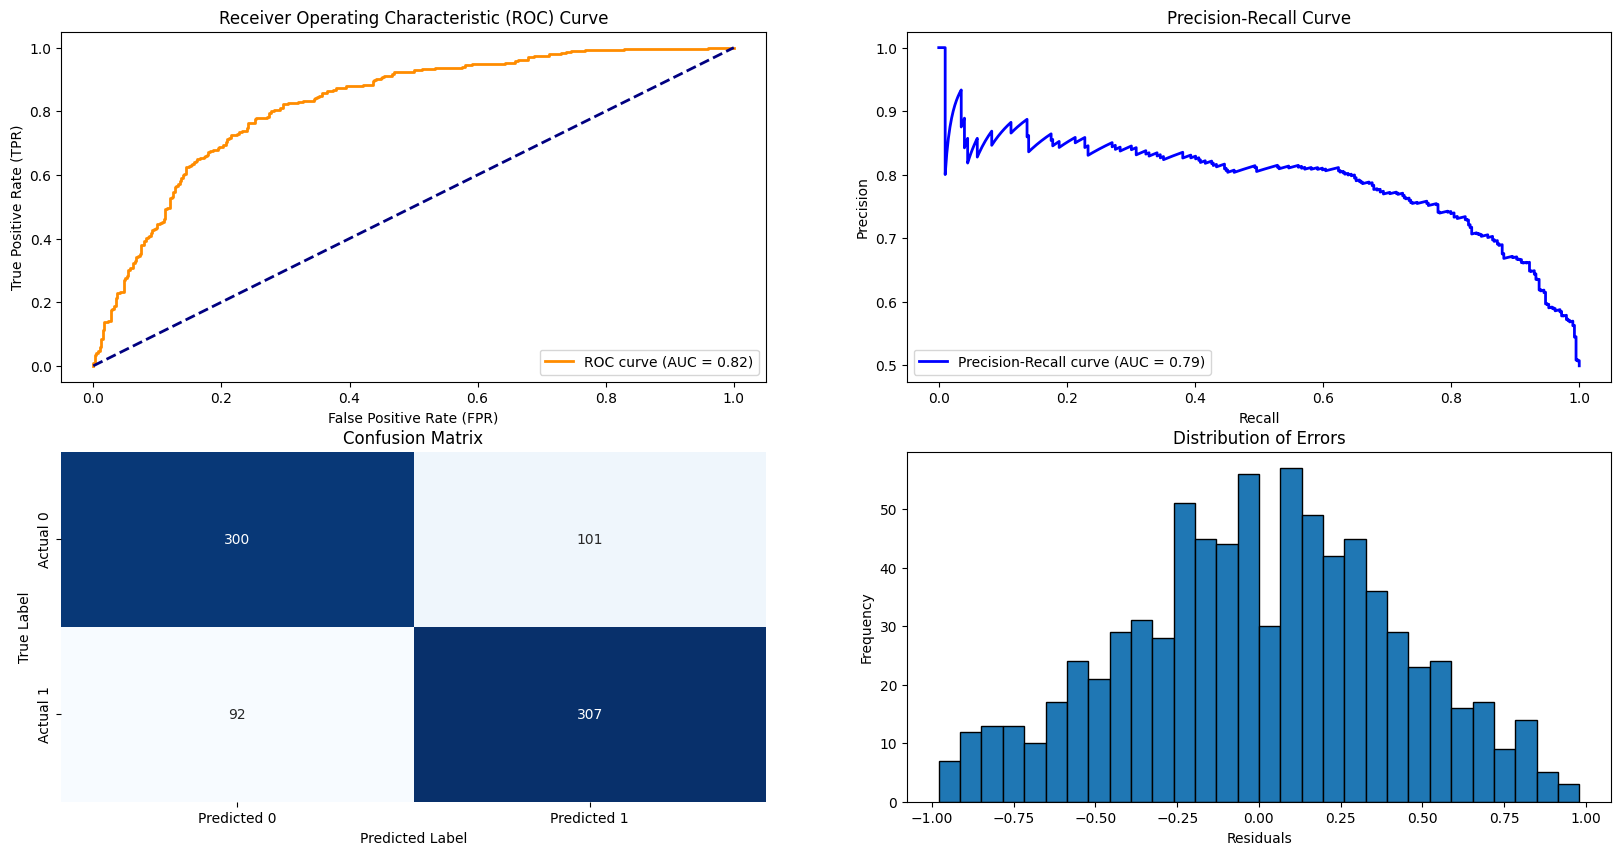

In [105]:
visualize_metrics(y_pred, y_test, y_probs)

# Decision Tree Classifier

In [106]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [1]:
y_pred = decision_tree_model.predict(X_test)
y_probs = decision_tree_model.predict_proba(X_test)[:,1]

NameError: name 'decision_tree_model' is not defined

In [19]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(r'R^2 Score: ',metrics.r2_score(y_test,y_pred))

Accuracy: 81.12%
R^2 Score:  0.2449952812205074


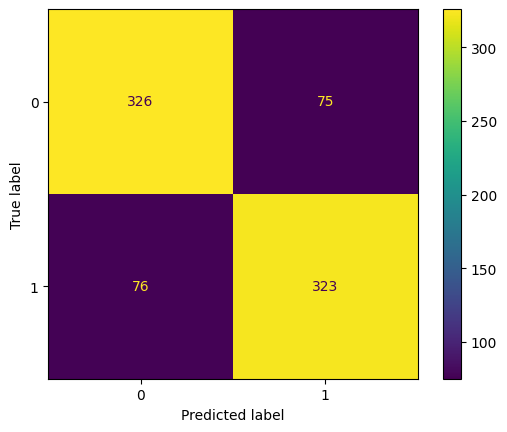

In [20]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## Grid Search

In [ ]:
param_grid = {
    'max_depth': [None, 5, 10, 15,20, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the model to the data (search for the best hyperparameters)
grid_search.fit(X_train, y_train)

In [21]:
#{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_tree_model = DecisionTreeClassifier(criterion='gini',max_depth=25, min_samples_leaf=1, min_samples_split=2)
best_tree_model.fit(X_train, y_train)
y_pred = best_tree_model.predict(X_test)

In [22]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(r'R^2 Score: ',metrics.r2_score(y_test,y_pred))

Accuracy: 81.00%
R^2 Score:  0.23999524997031207


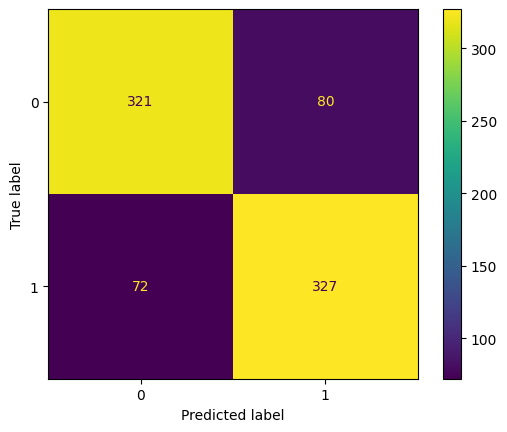

In [23]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## SVC

In [24]:
svc_model =SVC()

In [25]:
svc_model.fit(X_train, y_train)

SVC()

In [26]:
y_pred = svc_model.predict(X_test)

In [27]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.75%


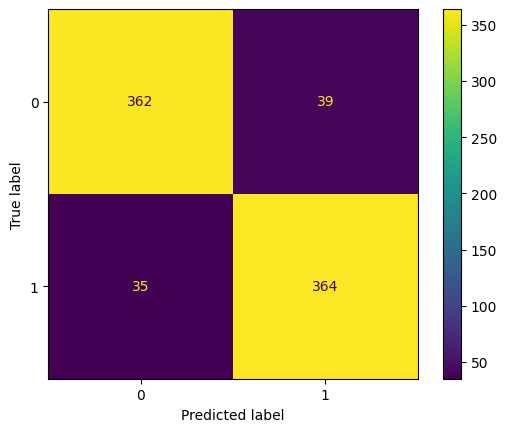

In [28]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

### Scaled Data

In [29]:
svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)

SVC()

In [30]:
y_pred = svc_model.predict(X_test_scaled)

In [31]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.12%


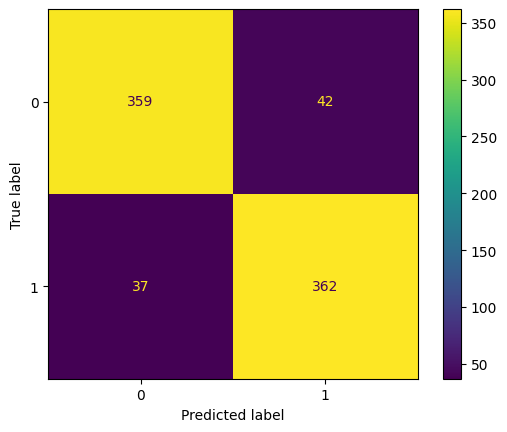

In [32]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

### Best model

In [33]:
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_params_)
#SVC(C = 10, gamma=0.1, kernel='rbf')

In [34]:
best_model = SVC(C=10, gamma=0.1, kernel='rbf')

In [35]:
best_model.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

In [36]:
y_pred = best_model.predict(X_test)

In [37]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 91.75%


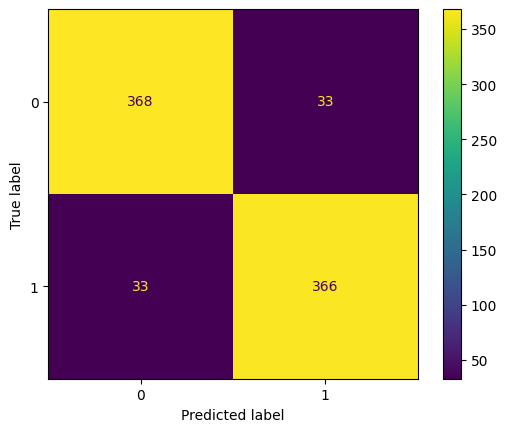

In [38]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## KNN

In [39]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
y_pred = knn_model.predict(X_test)

In [41]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 89.75%


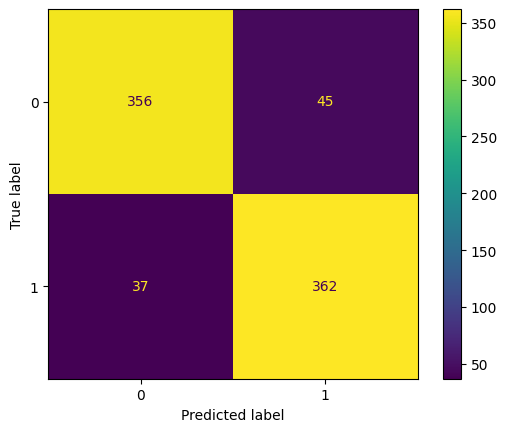

In [42]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

### Best k

In [45]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

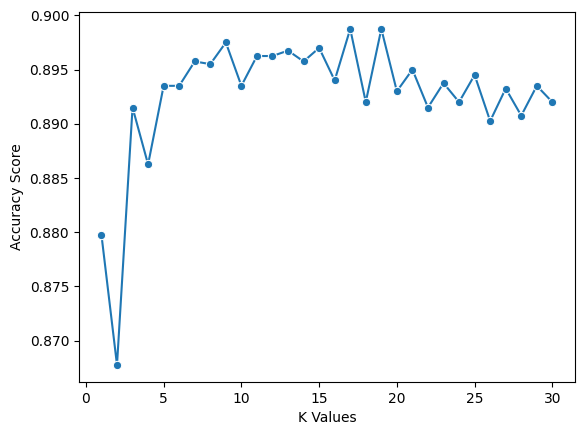

In [46]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [47]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

In [48]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [49]:
y_pred = knn.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Accuracy: 91.00%
Precision: 90.77%
Recall: 91.23%


## Gradient Boosting Classifier

In [101]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2,max_depth=5,min_samples_leaf=50,
                                 min_samples_split=40,max_features='sqrt', random_state=42).fit(X_train, y_train)

In [102]:
y_pred = gbc.predict(X_test)

In [103]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Accuracy: 89.38%
Precision: 89.25%
Recall: 89.47%


### Best model

In [112]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [35,50],
    'min_samples_split': [1,2,5],
    'min_samples_leaf': [5],
    'subsample': [0.8],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

In [116]:
print(grid_search.best_params_)
#{'learning_rate': 0.2, 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}

{'learning_rate': 0.2, 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}


In [117]:
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.2,max_depth=35,min_samples_leaf=5,
                                 min_samples_split=2,max_features='sqrt',subsample=0.8, random_state=42).fit(X_train, y_train)

In [118]:
y_pred = gbc.predict(X_test)

In [119]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Accuracy: 90.12%
Precision: 90.00%
Recall: 90.23%


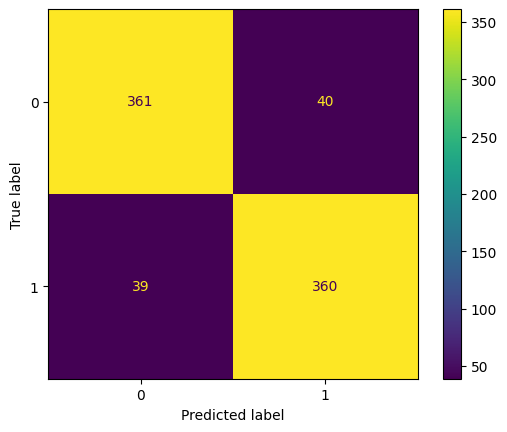

In [120]:
labels = [0,1,]
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## Neural Network

In [ ]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
test_ds = TensorDataset(X_test,y_test )
train_ds = TensorDataset(X_train, y_train)

In [ ]:
class Model(nn.Module):
    def __init__(self,
                 input_features:int,
                 hidden_size:int,
                 dropout_rate:float,
                 output:int):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features,2*hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2*hidden_size,4*hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(4*hidden_size,1),
            )
        self.float()
    
    def forward(self,x):
        return self.linear_stack(x)

In [ ]:
model = Model(input_features=X_train.shape[1],
               hidden_size=16,
               dropout_rate=.2,
               output=1)
learning_rate = 0.002
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
num_epochs = 1000
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
accuracy_test_hist = [0] * num_epochs
train_loss = []
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        y_logits = model(x_batch).squeeze()
        output_prob = torch.sigmoid(y_logits)
        y_pred = output_prob > 0.5
        loss = loss_fn(y_logits, y_batch) 
        acc = accuracy_fn(y_true=y_batch, y_pred=y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy_hist.append(acc)
    train_loss.append(loss.item())
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.8f}, Accuracy: {acc:.2f}%")
    if epoch % 100 == 0:
        y_logits = model(X_test).squeeze()
        output_prob = torch.sigmoid(y_logits)
        y_pred = output_prob > 0.5
        acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
        accuracy_hist.append(acc)
        print(f"Epoch: {epoch} | Accuracy: {acc:.2f}%")

Save the model weights

In [ ]:
torch.save(model.state_dict(), './Weights/weights.torch')

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(10,8))
sns.lineplot(train_loss, ax=axes[0,0])
sns.lineplot(accuracy_hist, ax=axes[1,0])
